## **Criação dos Modelos de Aprendizado de Máquina - Risco de Inadimplência de Crédito Residencial**

## Importando bibliotecas - SETUP

In [1]:
import warnings, requests, zipfile, io
warnings.simplefilter('ignore')
import pandas as pd
from scipy.io import arff

import os
import boto3
import botocore 
import sagemaker
import numpy as np
import pandas as pd 
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
from sagemaker import get_execution_role 
from sagemaker.image_uris import retrieve
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## Lendo o conjunto de dados processados

In [2]:
bucket='credit2022processados'

In [3]:
prefix = 'EDA/a_train'

In [4]:
role = get_execution_role() 

data_key_train = 'a_train.csv' 
data_location_train = 's3://{}/{}/{}'.format(bucket, prefix, data_key_train) 

a_train = pd.read_csv(data_location_train) 
a_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,406597.5,351000.0,0.018801,9461,-637,-3648.0,...,0,0,1,0,1,0,0,1,0,1
1,100003,0,0,0,1293502.5,1129500.0,0.003541,16765,-1188,-1186.0,...,0,0,1,0,1,0,0,1,0,0
2,100004,1,1,1,135000.0,135000.0,0.010032,19046,-225,-4260.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,312682.5,297000.0,0.008019,19005,-3039,-9833.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,513000.0,513000.0,0.028663,19932,-3038,-4311.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,254700.0,225000.0,0.032561,9327,-236,-8456.0,...,0,0,1,0,1,0,0,1,0,0
307507,456252,0,0,1,269550.0,225000.0,0.025164,20775,365243,-4388.0,...,0,0,1,0,1,0,0,1,0,0
307508,456253,0,0,1,677664.0,585000.0,0.005002,14966,-7921,-6737.0,...,0,0,1,0,1,0,0,1,0,0
307509,456254,0,0,1,370107.0,319500.0,0.005313,11961,-4786,-2562.0,...,0,0,0,0,1,0,0,1,0,1


In [5]:
a_train.shape

(307511, 155)

In [6]:
a_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

<AxesSubplot:xlabel='TARGET', ylabel='count'>

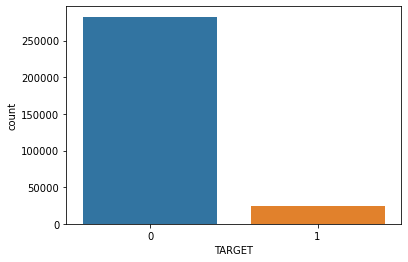

In [7]:
sns.countplot(x='TARGET',data=a_train)

In [8]:
prefix = 'EDA/a_test'

In [9]:
role = get_execution_role() 

data_key_test =  'a_test.csv' 
data_location_test = 's3://{}/{}/{}'.format(bucket, prefix, data_key_test) 

a_test = pd.read_csv(data_location_test) 
a_test

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100001,0,0,1,568800.0,450000.0,0.018850,-19241,-2329,-5170.0,...,0,0,0,0,0,1,0,0,1,0
1,100005,0,0,1,222768.0,180000.0,0.035792,-18064,-4469,-9118.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,1,1,663264.0,630000.0,0.019101,-20038,-4458,-2175.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,0,0,1,1575000.0,1575000.0,0.026392,-13976,-1866,-2000.0,...,0,0,0,1,0,1,0,0,1,0
4,100038,0,1,0,625500.0,625500.0,0.010032,-13040,-2191,-4000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48739,456221,0,0,1,412560.0,270000.0,0.002042,-19970,-5169,-9094.0,...,0,0,0,0,0,0,0,0,0,0
48740,456222,0,0,0,622413.0,495000.0,0.035792,-11186,-1149,-3015.0,...,0,0,0,0,0,0,0,0,0,0
48741,456223,0,1,1,315000.0,315000.0,0.026392,-15922,-3037,-2681.0,...,0,0,0,0,0,1,0,0,1,0
48742,456224,0,0,0,450000.0,450000.0,0.018850,-13968,-2731,-1461.0,...,0,0,0,0,0,1,0,0,1,0


In [10]:
a_test.shape

(48744, 154)

In [11]:
a_train.dtypes.value_counts()

int64      144
float64     11
dtype: int64

In [12]:
a_test.dtypes.value_counts()

int64      143
float64     11
dtype: int64

## Examinando valores ausentes

In [13]:
def missing_values_table(df):
        # Total de valores faltantes
        mis_val = df.isnull().sum()
        
        # Porcentagem de valores faltantes
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Fazendo uma tabela com valores faltantes
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Renomeando as colunas
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Classificando a tabela por porcentagem de falta decrescente
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Imprimindo frase com um reumo geral das informações de dados ausentes
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Retornar dataframe com informações ausentes
        return mis_val_table_ren_columns

In [14]:
# Missing values statistics
missing_values = missing_values_table(a_train)
missing_values.head(20)

Your selected dataframe has 155 columns.
There are 8 columns that have missing values.


,Missing Values,% of Total Values
OWN_CAR_AGE,202929,66.0
EXT_SOURCE_1,173378,56.4
APARTMENTS_AVG,156061,50.7
TOTALAREA_MODE,148431,48.3
EXT_SOURCE_3,60965,19.8
EXT_SOURCE_2,660,0.2
AMT_GOODS_PRICE,278,0.1
DAYS_LAST_PHONE_CHANGE,1,0.0


In [15]:
# Missing values statistics
missing_values = missing_values_table(a_test)
missing_values.head(20)

Your selected dataframe has 154 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
OWN_CAR_AGE,32312,66.3
APARTMENTS_AVG,23887,49.0
TOTALAREA_MODE,22624,46.4
EXT_SOURCE_1,20532,42.1
EXT_SOURCE_3,8668,17.8
EXT_SOURCE_2,8,0.0


## Analisando os tipos de dados presentes no dataframe

In [16]:
a_train.dtypes.value_counts()

int64      144
float64     11
dtype: int64

In [17]:
a_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

Series([], dtype: float64)

In [18]:
# Utilizando Label encoding
le = LabelEncoder()
le_count = 0

# Iterando nas colunas
for col in a_train:
    if a_train[col].dtype == 'object':
        # Se tiver duas categorias únicas ou menos:
        if len(list(a_train[col].unique())) <= 2:
            le.fit(a_train[col])
            a_train[col] = le.transform(a_train[col])
            a_test[col] = le.transform(a_test[col])
            
            # Acompanhando quantas colunas foram codificadas por rótulo
            le_count += 1
            
print('%d colunas foram codificadas por rótulo.' % le_count)

0 colunas foram codificadas por rótulo.


In [19]:
# one-hot encoding of categorical variables
a_train = pd.get_dummies(a_train)
a_test = pd.get_dummies(a_test)

print('Forma do conjunto de dados de treinamento: ', a_train.shape)
print('Forma do conjunto de dados de teste: ', a_test.shape)

Forma do conjunto de dados de treinamento:  (307511, 155)
Forma do conjunto de dados de teste:  (48744, 154)


## **Igualando número de colunas nos dataframes de treinamento e teste**

É necessário que haja as mesmas colunas nos dados de treinamento e teste. A codificação one-hot criou mais colunas nos dados de treinamento porque havia algumas variáveis colunas com categorias não representadas nos dados de teste. Para remover as colunas nos dados de treinamento que não estão nos dados de teste, precisamos alinhar os dataframes. Primeiro, extraímos a coluna de destino dos dados de treinamento (porque isso não está nos dados de teste, mas precisamos manter essas informações). Quando fazemos o alinhamento, devemos nos certificar de definir axis = 1 para alinhar os dataframes com base nas colunas e não nas linhas!

In [20]:
train_labels = a_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
a_train, a_test = a_train.align(a_test, join = 'inner', axis = 1)

# Add the target back in
a_train['TARGET'] = train_labels

print('Forma do conjunto de dados de treinamento: ', a_train.shape)
print('Forma do conjunto de dados de teste: ', a_test.shape)

Forma do conjunto de dados de treinamento:  (307511, 155)
Forma do conjunto de dados de teste:  (48744, 154)


## Imputação de valores faltantes (células vazias)

In [21]:
def missing_val_ratio(a_train):
    perc_na = (a_train.isnull().sum()/len(a_train))*100
    ratio_na = perc_na.sort_values(ascending=False)
    missing_data_table = pd.DataFrame({'% of Total Values' :ratio_na})
    return missing_data_table

In [22]:
a_train_miss = missing_val_ratio(a_train)
a_train_miss.head(20)

,% of Total Values
OWN_CAR_AGE,65.990810
EXT_SOURCE_1,56.381073
APARTMENTS_AVG,50.749729
TOTALAREA_MODE,48.268517
EXT_SOURCE_3,19.825307
EXT_SOURCE_2,0.214626
AMT_GOODS_PRICE,0.090403
DAYS_LAST_PHONE_CHANGE,0.000325
ORGANIZATION_TYPE_Industry: type 2,0.000000
ORGANIZATION_TYPE_Industry: type 10,0.000000


In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range = (0, 1)) 

In [24]:
for column in a_train.columns:
    a_train[[column]] = imputer.fit_transform(a_train[[column]])
    a_train[[column]] = scaler.fit_transform(a_train[[column]])

In [25]:
a_train_miss = missing_val_ratio(a_train)
a_train_miss.head(25)

,% of Total Values
SK_ID_CURR,0.0
ORGANIZATION_TYPE_Industry: type 2,0.0
ORGANIZATION_TYPE_Hotel,0.0
ORGANIZATION_TYPE_Housing,0.0
ORGANIZATION_TYPE_Industry: type 1,0.0
ORGANIZATION_TYPE_Industry: type 10,0.0
ORGANIZATION_TYPE_Industry: type 11,0.0
ORGANIZATION_TYPE_Industry: type 12,0.0
ORGANIZATION_TYPE_Industry: type 13,0.0
ORGANIZATION_TYPE_Industry: type 3,0.0


In [26]:
a_train

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,0.000000,0.0,0.0,1.0,0.090287,0.077441,0.256321,0.111161,0.045086,0.852140,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,0.000003,0.0,0.0,0.0,0.311736,0.271605,0.045016,0.522886,0.043648,0.951929,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.000006,1.0,1.0,1.0,0.022472,0.023569,0.134897,0.651466,0.046161,0.827335,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000011,0.0,0.0,1.0,0.066837,0.063973,0.107023,0.649154,0.038817,0.601451,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000014,0.0,0.0,1.0,0.116854,0.117845,0.392880,0.701409,0.038820,0.825268,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.999989,0.0,0.0,0.0,0.052360,0.046016,0.446855,0.103608,0.046133,0.657263,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307507,0.999992,0.0,0.0,1.0,0.056067,0.046016,0.344429,0.748929,1.000000,0.822147,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307508,0.999994,0.0,0.0,1.0,0.157969,0.135802,0.065247,0.421477,0.026076,0.726937,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
307509,0.999997,0.0,0.0,1.0,0.081175,0.069585,0.069553,0.252086,0.034258,0.896158,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [27]:
a_test_miss = missing_val_ratio(a_test)
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range = (0, 1))
for column in a_test.columns:
    a_test[[column]] = imputer.fit_transform(a_test[[column]])
    a_test[[column]] = scaler.fit_transform(a_test[[column]])
a_test_miss = missing_val_ratio(a_test)
a_test_miss.head(25)

,% of Total Values
SK_ID_CURR,0.0
ORGANIZATION_TYPE_Industry: type 13,0.0
ORGANIZATION_TYPE_Government,0.0
ORGANIZATION_TYPE_Hotel,0.0
ORGANIZATION_TYPE_Housing,0.0
ORGANIZATION_TYPE_Industry: type 1,0.0
ORGANIZATION_TYPE_Industry: type 10,0.0
ORGANIZATION_TYPE_Industry: type 11,0.0
ORGANIZATION_TYPE_Industry: type 12,0.0
ORGANIZATION_TYPE_Industry: type 2,0.0


In [28]:
a_train.shape

(307511, 155)

In [29]:
a_train.dtypes.value_counts()

float64    155
dtype: int64

In [30]:
a_test.shape

(48744, 154)

In [31]:
a_test.dtypes.value_counts()

float64    154
dtype: int64

## Ajustando o dataframe para dar início à criação dos modelos

In [32]:
first_column = a_train.pop('TARGET')
a_train.insert(0, 'TARGET', first_column)

In [33]:
a_train

,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,1.0,0.000000,0.0,0.0,1.0,0.090287,0.077441,0.256321,0.111161,0.045086,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
1,0.0,0.000003,0.0,0.0,0.0,0.311736,0.271605,0.045016,0.522886,0.043648,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
2,0.0,0.000006,1.0,1.0,1.0,0.022472,0.023569,0.134897,0.651466,0.046161,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000011,0.0,0.0,1.0,0.066837,0.063973,0.107023,0.649154,0.038817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000014,0.0,0.0,1.0,0.116854,0.117845,0.392880,0.701409,0.038820,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0.0,0.999989,0.0,0.0,0.0,0.052360,0.046016,0.446855,0.103608,0.046133,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307507,0.0,0.999992,0.0,0.0,1.0,0.056067,0.046016,0.344429,0.748929,1.000000,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307508,0.0,0.999994,0.0,0.0,1.0,0.157969,0.135802,0.065247,0.421477,0.026076,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
307509,1.0,0.999997,0.0,0.0,1.0,0.081175,0.069585,0.069553,0.252086,0.034258,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


# Modelling

## XGBoost (Modelo 01)

In [34]:
from sklearn.model_selection import train_test_split
train, test_and_validate = train_test_split(a_train, test_size = 0.2, random_state = 42, stratify = a_train['TARGET'])

In [35]:
test, validate = train_test_split(test_and_validate, test_size = 0.5, random_state = 42, stratify = test_and_validate['TARGET'])

In [36]:
print(train.shape)
print(test.shape)
print(validate.shape)

(246008, 155)
(30751, 155)
(30752, 155)


In [37]:
print(train['TARGET'].value_counts())
print(test['TARGET'].value_counts())
print(validate['TARGET'].value_counts())

0.0    226148
1.0     19860
Name: TARGET, dtype: int64
0.0    28269
1.0     2482
Name: TARGET, dtype: int64
0.0    28269
1.0     2483
Name: TARGET, dtype: int64


Uploading the data to Amazon S3

In [38]:
bucket = 'credit2022results'

In [39]:
prefix = 'XGBoost_01'

In [40]:
train_file='part_train.csv'
test_file='part_test.csv'
validate_file='part_validate.csv'

In [41]:
s3_resource = boto3.Session().resource('s3')
def upload_s3_csv(filename, folder, dataframe):
    csv_buffer = io.StringIO()
    dataframe.to_csv(csv_buffer, header=False, index=False )
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

In [42]:
upload_s3_csv(train_file, 'train', train)
upload_s3_csv(test_file, 'test', test)
upload_s3_csv(validate_file, 'validate', validate)

In [43]:
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')

In [44]:
hyperparams={"num_round":"42",
             "eval_metric": "auc",
             "objective": "binary:logistic"}

In [45]:
s3_output_location="s3://{}/{}/output/".format(bucket,prefix)
xgb_model=sagemaker.estimator.Estimator(container,
                                       sagemaker.get_execution_role(),
                                       instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       output_path=s3_output_location,
                                        hyperparameters=hyperparams,
                                        sagemaker_session=sagemaker.Session())

In [46]:
train_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/".format(bucket,prefix,train_file),
    content_type='text/csv')

In [47]:
validate_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/".format(bucket,prefix,validate_file),
    content_type='text/csv')

In [48]:
data_channels = {'train': train_channel, 'validation': validate_channel}


In [49]:
xgb_model.fit(inputs=data_channels, logs=False)


2022-11-27 21:18:58 Starting - Starting the training job.....
2022-11-27 21:19:26 Starting - Preparing the instances for training................
2022-11-27 21:20:53 Downloading - Downloading input data.......
2022-11-27 21:21:33 Training - Downloading the training image.........
2022-11-27 21:22:24 Training - Training image download completed. Training in progress.........
2022-11-27 21:23:09 Uploading - Uploading generated training model..
2022-11-27 21:23:25 Completed - Training job completed


In [50]:
batch_X = test.iloc[:,1:];

In [51]:
batch_X_file='batch-in.csv'
upload_s3_csv(batch_X_file, 'batch-in', batch_X)

In [52]:
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

In [53]:
xgb_transformer = xgb_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)

In [54]:
xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')

...................................[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2022-11-27 21:29:07 +0000] [18] [INFO] Starting 

In [55]:
xgb_transformer.wait()

[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:29:07:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
   

## Explorando os resultados

In [56]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])
target_predicted.head(15)

,class
0,0.051363
1,0.055564
2,0.068542
3,0.014509
4,0.055072
5,0.171781
6,0.029474
7,0.056715
8,0.050838
9,0.023310


In [57]:
def binary_convert(x):
    threshold = 0.3
    if x > threshold:
        return 1
    else:
        return 0

In [58]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)

OBS: A primeira saída da tabela serão os _predicted values_ (valores
previstos), e a segunda saída da tabela serão os _original test data_
(dados de teste originais).

In [59]:
print(target_predicted_binary.head(5))
test.head(5)

0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64


,TARGET,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_CREDIT,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,ORGANIZATION_TYPE_XNA,FONDKAPREMONT_MODE_not specified,FONDKAPREMONT_MODE_org spec account,FONDKAPREMONT_MODE_reg oper account,FONDKAPREMONT_MODE_reg oper spec account,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
133535,0.0,0.434725,0.0,0.0,1.0,0.067582,0.062851,1.000000,0.366234,0.034837,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
158392,0.0,0.515417,0.0,1.0,0.0,0.262200,0.248036,0.134897,0.423901,0.037176,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
6922,0.0,0.022630,1.0,1.0,1.0,0.073034,0.074074,0.129705,0.232018,0.045598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63020,0.0,0.205174,0.0,0.0,0.0,0.509393,0.438833,1.000000,0.413191,0.046214,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
84644,0.0,0.275650,0.0,0.0,1.0,0.318170,0.277217,0.090864,0.510936,0.025830,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Criando de uma matriz de confusão (confusion matrix)

In [60]:
test_labels = test.iloc[:,0]
test_labels.head()

133535    0.0
158392    0.0
6922      0.0
63020     0.0
84644     0.0
Name: TARGET, dtype: float64

In [61]:
from sklearn.metrics import confusion_matrix

In [62]:
matrix = confusion_matrix(test_labels, target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Reembolsa','Não reembolsa'],columns=['Reembolsa','Não reembolsa'])

In [63]:
df_confusion

,Reembolsa,Não reembolsa
Reembolsa,27743,526
Não reembolsa,2156,326


In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

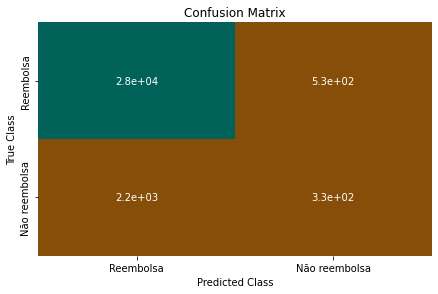

In [65]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## Cálculo dos dados estatísticos de desempenho

In [66]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

In [67]:
TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()

In [68]:
print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 27743
False Positive (FP): 526
False Negative (FN): 2156
True Positive (TP) : 326


In [69]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 13.13456889605157%
There is a 13.13456889605157% chance of detecting patients with an abnormality have an abnormality


In [70]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")

Specificity or TNR: 98.13930453854044%
There is a 98.13930453854044% chance of detecting normal patients are normal.


In [71]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 38.26291079812207%
You have an abnormality, and the probablity that is correct is 38.26291079812207%


In [72]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 92.78905649018363%
You don't have an abnormality, but there is a 92.78905649018363% chance that is incorrect


In [73]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 1.8606954614595494%
There is a 1.8606954614595494% chance that this positive result is incorrect.


In [74]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 86.86543110394844%
There is a 86.86543110394844% chance that this negative result is incorrect.


In [75]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 61.737089201877936%
You have an abnormality, but there is a 61.737089201877936% chance this is incorrect.


In [76]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 91.27833241195408%


In [77]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%")

Sensitivity or TPR: 13.13456889605157%
Specificity or TNR: 98.13930453854044%
Precision: 38.26291079812207%
Negative Predictive Value: 92.78905649018363%
False Positive Rate: 1.8606954614595494%
False Negative Rate: 86.86543110394844%
False Discovery Rate: 61.737089201877936%
Accuracy: 91.27833241195408%


## Cálculo do AUC-ROC

In [78]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, target_predicted) )

Validation AUC 0.7500147369739474


In [79]:
fpr, tpr, thresholds = roc_curve(test_labels, target_predicted)
roc_auc = auc(fpr, tpr)

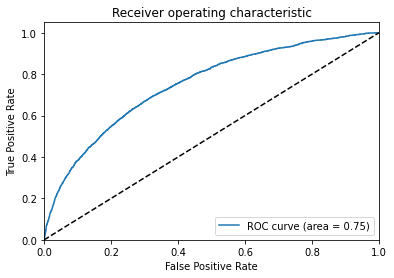

In [80]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

(0.0, 1.0)

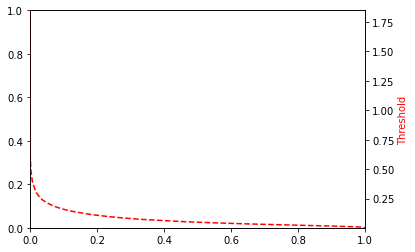

In [81]:
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [82]:
print(plt.figure())

Figure(432x288)


<Figure size 432x288 with 0 Axes>

## Ajuste dos hiperparâmetros

In [83]:
%%time
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

xgb = sagemaker.estimator.Estimator(container,
                                    role=sagemaker.get_execution_role(), 
                                    instance_count= 1, # make sure you have limit set for these instances
                                    instance_type='ml.m4.xlarge', 
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())


xgb.set_hyperparameters(eval_metric='error@.40',
                        objective='binary:logistic',
                        num_round=42)

hyperparameter_ranges = {'alpha': ContinuousParameter(0, 100),
                         'min_child_weight': ContinuousParameter(1, 5),
                         'subsample': ContinuousParameter(0.5, 1),
                         'eta': ContinuousParameter(0.1, 0.3),  
                         'num_round': IntegerParameter(1,50)
                         }

objective_metric_name = 'validation:error'
objective_type = 'Minimize'

tuner = HyperparameterTuner(xgb,
                            objective_metric_name,
                            hyperparameter_ranges,
                            max_jobs=10, # Set this to 10 or above depending upon budget & available time.
                            max_parallel_jobs=1,
                            objective_type=objective_type,
                            early_stopping_type='Auto')

tuner.fit(inputs=data_channels, include_cls_metadata=False)
tuner.wait()

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


......................................................................................................................................................................................................................................................................!
!
CPU times: user 1.18 s, sys: 129 ms, total: 1.31 s
Wall time: 22min 6s


In [84]:
boto3.client('sagemaker').describe_hyper_parameter_tuning_job(
    HyperParameterTuningJobName=tuner.latest_tuning_job.job_name)['HyperParameterTuningJobStatus']

'Completed'

## Verificando o resultado do ajuste de hiperparâmetros (tuning jobs)

In [85]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

tuner_analytics = HyperparameterTuningJobAnalytics(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())

df_tuning_job_analytics = tuner_analytics.dataframe()

# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    by=['FinalObjectiveValue'],
    inplace=True,
    ascending=False if tuner.objective_type == "Maximize" else True)

# Show detailed analytics for the top 20 models
df_tuning_job_analytics.head(20)

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
1,68.756530,0.235254,1.876447,49.0,0.569299,sagemaker-xgboost-221127-2129-009-f22c52b0,Stopped,0.07993,2022-11-27 21:48:25+00:00,2022-11-27 21:49:54+00:00,89.0
6,79.712398,0.285719,3.441795,44.0,0.547216,sagemaker-xgboost-221127-2129-004-35ef4dc2,Completed,0.07999,2022-11-27 21:37:17+00:00,2022-11-27 21:38:49+00:00,92.0
0,58.418583,0.259008,3.060715,50.0,0.833525,sagemaker-xgboost-221127-2129-010-af6a1941,Completed,0.08009,2022-11-27 21:50:07+00:00,2022-11-27 21:51:44+00:00,97.0
3,27.493176,0.295056,3.509944,35.0,0.789321,sagemaker-xgboost-221127-2129-007-478b4f66,Completed,0.08009,2022-11-27 21:45:40+00:00,2022-11-27 21:46:58+00:00,78.0
5,50.726297,0.225795,1.083899,35.0,0.933329,sagemaker-xgboost-221127-2129-005-f5596145,Completed,0.08013,2022-11-27 21:41:44+00:00,2022-11-27 21:44:08+00:00,144.0
9,38.452357,0.143557,4.694832,45.0,0.732768,sagemaker-xgboost-221127-2129-001-93a1030f,Completed,0.08038,2022-11-27 21:32:12+00:00,2022-11-27 21:34:50+00:00,158.0
8,2.780080,0.287207,2.846082,3.0,0.719777,sagemaker-xgboost-221127-2129-002-e1f2e72c,Completed,0.08045,2022-11-27 21:35:08+00:00,2022-11-27 21:35:55+00:00,47.0
7,83.522570,0.272989,2.679064,12.0,0.633658,sagemaker-xgboost-221127-2129-003-2a7ef37c,Completed,0.08058,2022-11-27 21:36:07+00:00,2022-11-27 21:36:59+00:00,52.0
2,46.349989,0.139413,2.211348,34.0,0.869404,sagemaker-xgboost-221127-2129-008-7d9c47d6,Stopped,0.08061,2022-11-27 21:47:21+00:00,2022-11-27 21:48:13+00:00,52.0
4,19.935544,0.206247,4.647080,9.0,0.839720,sagemaker-xgboost-221127-2129-006-f531cd32,Completed,0.08064,2022-11-27 21:44:26+00:00,2022-11-27 21:45:28+00:00,62.0


In [86]:
attached_tuner = HyperparameterTuner.attach(tuner.latest_tuning_job.name, sagemaker_session=sagemaker.Session())
best_training_job = attached_tuner.best_training_job()

In [87]:
from sagemaker.estimator import Estimator
algo_estimator = Estimator.attach(best_training_job)

best_algo_model = algo_estimator.create_model(env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"})


2022-11-27 21:50:00 Starting - Found matching resource for reuse
2022-11-27 21:50:00 Downloading - Downloading input data
2022-11-27 21:50:00 Training - Training image download completed. Training in progress.
2022-11-27 21:50:00 Uploading - Uploading generated training model
2022-11-27 21:50:00 Completed - Resource retained for reuse


In [88]:
%%time
batch_output = "s3://{}/{}/batch-out/".format(bucket,prefix)
batch_input = "s3://{}/{}/batch-in/{}".format(bucket,prefix,batch_X_file)

xgb_transformer = best_algo_model.transformer(instance_count=1,
                                       instance_type='ml.m4.xlarge',
                                       strategy='MultiRecord',
                                       assemble_with='Line',
                                       output_path=batch_output)


xgb_transformer.transform(data=batch_input,
                         data_type='S3Prefix',
                         content_type='text/csv',
                         split_type='Line')
xgb_transformer.wait(logs=False)

...................................[2022-11-27:21:57:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:57:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:57:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:57:31:INFO] No GPUs detected (normal if no gpus installed)
[2022-11-27:21:57:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
[2022-11-27:21:57:31:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invoca

## Avaliando novamente os resultados

In [89]:
s3 = boto3.client('s3')
obj = s3.get_object(Bucket=bucket, Key="{}/batch-out/{}".format(prefix,'batch-in.csv.out'))
best_target_predicted = pd.read_csv(io.BytesIO(obj['Body'].read()),',',names=['class'])

def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

best_target_predicted_binary = best_target_predicted['class'].apply(binary_convert)
test_labels = test.iloc[:,0]

## Criando uma nova matriz de confusão (confusion matrix)

In [90]:
test_labels = test.iloc[:,0]
test_labels.head()

133535    0.0
158392    0.0
6922      0.0
63020     0.0
84644     0.0
Name: TARGET, dtype: float64

In [91]:
matrix = confusion_matrix(test_labels, best_target_predicted_binary)
df_confusion = pd.DataFrame(matrix, index=['Reembolsa','Não reembolsa'],columns=['Reembolsa','Não reembolsa'])

In [92]:
df_confusion

,Reembolsa,Não reembolsa
Reembolsa,28220,49
Não reembolsa,2427,55


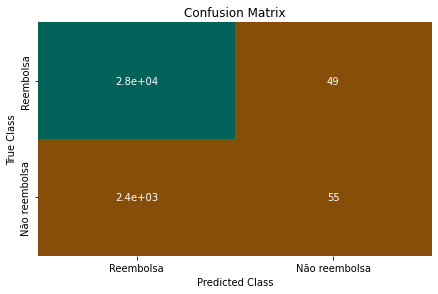

In [93]:
colormap = sns.color_palette("BrBG", 10)
sns.heatmap(df_confusion, annot=True, cbar=None, cmap=colormap)
plt.title("Confusion Matrix")
plt.tight_layout()
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
plt.show()

## Recalculando os dados estatísticos de desempenho

In [94]:
TN, FP, FN, TP = confusion_matrix(test_labels, best_target_predicted_binary).ravel()

In [95]:
print(f"True Negative (TN) : {TN}")
print(f"False Positive (FP): {FP}")
print(f"False Negative (FN): {FN}")
print(f"True Positive (TP) : {TP}")

True Negative (TN) : 28220
False Positive (FP): 49
False Negative (FN): 2427
True Positive (TP) : 55


In [96]:
# Sensitivity, hit rate, recall, or true positive rate
Sensitivity  = float(TP)/(TP+FN)*100
print(f"Sensitivity or TPR: {Sensitivity}%")  
print(f"There is a {Sensitivity}% chance of detecting patients with an abnormality have an abnormality")

Sensitivity or TPR: 2.215954875100725%
There is a 2.215954875100725% chance of detecting patients with an abnormality have an abnormality


In [97]:
# Specificity or true negative rate
Specificity  = float(TN)/(TN+FP)*100
print(f"Specificity or TNR: {Specificity}%") 
print(f"There is a {Specificity}% chance of detecting normal patients are normal.")

Specificity or TNR: 99.82666525168912%
There is a 99.82666525168912% chance of detecting normal patients are normal.


In [98]:
# Precision or positive predictive value
Precision = float(TP)/(TP+FP)*100
print(f"Precision: {Precision}%")  
print(f"You have an abnormality, and the probablity that is correct is {Precision}%")

Precision: 52.88461538461539%
You have an abnormality, and the probablity that is correct is 52.88461538461539%


In [99]:
# Negative predictive value
NPV = float(TN)/(TN+FN)*100
print(f"Negative Predictive Value: {NPV}%") 
print(f"You don't have an abnormality, but there is a {NPV}% chance that is incorrect" )

Negative Predictive Value: 92.08079094201716%
You don't have an abnormality, but there is a 92.08079094201716% chance that is incorrect


In [100]:
# Fall out or false positive rate
FPR = float(FP)/(FP+TN)*100
print( f"False Positive Rate: {FPR}%") 
print( f"There is a {FPR}% chance that this positive result is incorrect.")

False Positive Rate: 0.17333474831087056%
There is a 0.17333474831087056% chance that this positive result is incorrect.


In [101]:
# False negative rate
FNR = float(FN)/(TP+FN)*100
print(f"False Negative Rate: {FNR}%") 
print(f"There is a {FNR}% chance that this negative result is incorrect.")

False Negative Rate: 97.78404512489928%
There is a 97.78404512489928% chance that this negative result is incorrect.


In [102]:
# False discovery rate
FDR = float(FP)/(TP+FP)*100
print(f"False Discovery Rate: {FDR}%" )
print(f"You have an abnormality, but there is a {FDR}% chance this is incorrect.")

False Discovery Rate: 47.11538461538461%
You have an abnormality, but there is a 47.11538461538461% chance this is incorrect.


In [103]:
# Overall accuracy
ACC = float(TP+TN)/(TP+FP+FN+TN)*100
print(f"Accuracy: {ACC}%") 

Accuracy: 91.94822932587559%


In [104]:
print(f"Sensitivity or TPR: {Sensitivity}%")    
print(f"Specificity or TNR: {Specificity}%") 
print(f"Precision: {Precision}%")   
print(f"Negative Predictive Value: {NPV}%")  
print( f"False Positive Rate: {FPR}%") 
print(f"False Negative Rate: {FNR}%")  
print(f"False Discovery Rate: {FDR}%" )
print(f"Accuracy: {ACC}%")

Sensitivity or TPR: 2.215954875100725%
Specificity or TNR: 99.82666525168912%
Precision: 52.88461538461539%
Negative Predictive Value: 92.08079094201716%
False Positive Rate: 0.17333474831087056%
False Negative Rate: 97.78404512489928%
False Discovery Rate: 47.11538461538461%
Accuracy: 91.94822932587559%


## Recalculando AUC-ROC

In [105]:
test_labels = test.iloc[:,0];
print("Validation AUC", roc_auc_score(test_labels, best_target_predicted) )

Validation AUC 0.750781586957738


In [106]:
fpr, tpr, thresholds = roc_curve(test_labels, best_target_predicted)
roc_auc = auc(fpr, tpr)

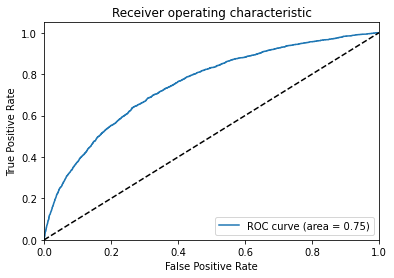

In [107]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

(0.0, 1.0)

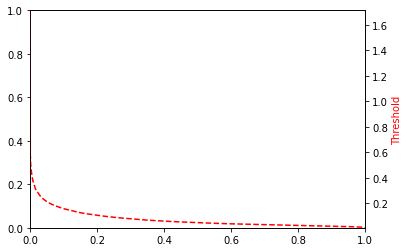

In [108]:
# create the axis of thresholds (scores)
ax2 = plt.gca().twinx()
ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
ax2.set_ylabel('Threshold',color='r')
ax2.set_ylim([thresholds[-1],thresholds[0]])
ax2.set_xlim([fpr[0],fpr[-1]])

In [109]:
print(plt.figure())

Figure(432x288)


<Figure size 432x288 with 0 Axes>

## Deploy

In [110]:
xgb_predictor = xgb_model.deploy(initial_instance_count=1,
                serializer = sagemaker.serializers.CSVSerializer(),
                instance_type='ml.m4.xlarge')

-------!

## Regressão Logistica

In [111]:
y = a_train['TARGET']
X = a_train.drop(labels=['TARGET'],axis=1)

In [112]:
#prediction is on y_train
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

In [113]:
from sklearn.linear_model import LogisticRegression
print(X_train.shape)
print(X_valid.shape)

(215257, 154)
(92254, 154)


In [114]:

# TREINAMENTO
clf_logistic = LogisticRegression(solver='lbfgs')
clf_logistic_fit = clf_logistic.fit(X_train,y_train)
#clf_logistic_fit.coef_

In [115]:
probs=pd.DataFrame(clf_logistic.predict_proba(X_valid)).head()
probs

,0,1
0,0.963493,0.036507
1,0.917126,0.082874
2,0.966487,0.033513
3,0.921054,0.078946
4,0.453081,0.546919


In [116]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix,classification_report,recall_score,accuracy_score,precision_score
from sklearn.model_selection import train_test_split

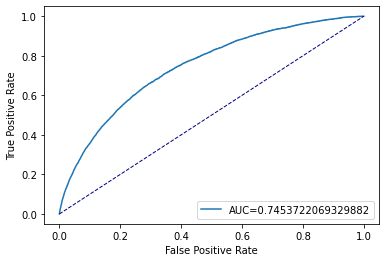

In [117]:
#VALIDAÇÃO
y_pred = clf_logistic_fit.predict(X_valid)
y_pred_proba = clf_logistic_fit.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve( y_valid,  y_pred_proba)
auc = metrics.roc_auc_score( y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [118]:
print (classification_report(y_true=y_valid,
                            y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84787
         1.0       0.48      0.01      0.02      7467

    accuracy                           0.92     92254
   macro avg       0.70      0.50      0.49     92254
weighted avg       0.88      0.92      0.88     92254



In [119]:
acc1=accuracy_score(y_true=y_valid,
               y_pred=y_pred)
print('Logistic regression accuracy_score',acc1)

Logistic regression accuracy_score 0.9189845426756563


In [120]:
matrix = confusion_matrix(y_valid, y_pred)
matrix

array([[84710,    77],
       [ 7397,    70]])

## Randon Forest

In [123]:
y = a_train['TARGET']
X = a_train.drop(labels=['TARGET'],axis=1)

In [124]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

In [125]:
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

In [126]:
#X=X_train
#y=y_train
#X_train, X_valid, y_train, y_valid = train_test_split(X,y,test_size=.30,random_state=1)

# TREINAMENTO
param_grid={'max_depth':range(1,20,2)}
forest = RandomForestClassifier()
random_forest = GridSearchCV(forest, param_grid, cv=5, scoring='accuracy',n_jobs=-1).fit(X_train,y_train)

# VALIDAÇÃO
y_pred = random_forest.predict(X_valid)
print(classification_report(y_true=y_valid, y_pred=y_pred))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     84787
         1.0       1.00      0.00      0.00      7467

    accuracy                           0.92     92254
   macro avg       0.96      0.50      0.48     92254
weighted avg       0.93      0.92      0.88     92254



In [127]:
print(accuracy_score(y_valid,y_pred))

0.9190712597827736


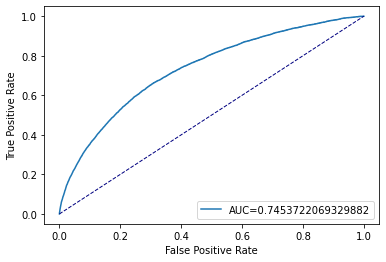

In [128]:
y_pred_proba = random_forest.predict_proba(X_valid)[::,1]
fpr, tpr, _ = metrics.roc_curve( y_valid,  y_pred_proba)
auc_f = metrics.roc_auc_score( y_valid, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

## Comparação entre os 3 métodos de ML

Text(0, 0.5, 'Auc')

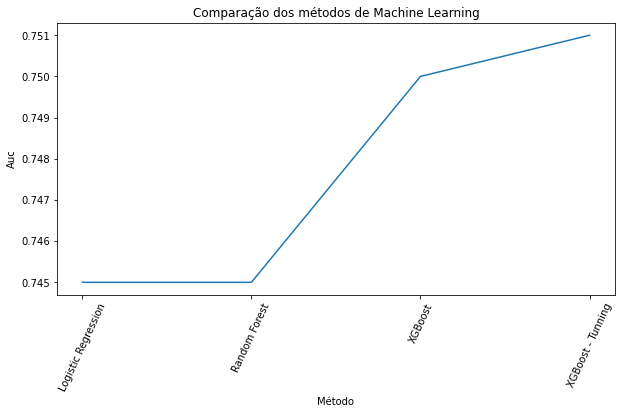

In [136]:
name = ['Logistic Regression','Random Forest','XGBoost', 'XGBoost - Tunning']
auc_f = [0.745,0.745,0.75, 0.751]
plt.figure(figsize=(10,5))
sns.lineplot(x=name,y=auc_f)
plt.xticks(rotation=65)
plt.title('Comparação dos métodos de Machine Learning')
plt.xlabel('Método')
plt.ylabel('Auc')

Este gráfico mostra que o XGBoost teve um desepenho melhor que os outros dois modelos

## Teste

## Regressão Logistica
O treinamento de Regressão logistica aplicado no csv de teste predizeu apenas 0,2% de clientes potenciais inadimplentes. 

In [130]:
y_pred_LOGISTIC = clf_logistic_fit.predict(a_test)
print((y_pred_LOGISTIC == 0).sum())
print((y_pred_LOGISTIC == 1).sum())

48655
89


## Random Forest
O treinamento de Random Forest aplicado no csv de teste não detectou potenciais clientes inadimplentes.

In [131]:
y_pred_FOREST = random_forest.predict(a_test)
print((y_pred_FOREST == 0).sum())
print((y_pred_FOREST == 1).sum())

48743
1


In [132]:
a_test['TARGET_L'] = y_pred_LOGISTIC
a_test['TARGET_F'] = y_pred_FOREST
a_test.to_csv('a_test_with_targets.csv')

O resultado do Random forest mostra o quão problematico é o desbalanceamento do dataframe. O modelo não encontrou nenhum caso de potencial cliente devedor, isto para uma empresa representa um alto risco de crédito a perfis que o modelo não conseguiu identificar. Esta conclusão só se deve pq é esperado que ao menos 8% do dataset sejam possiveis inadimplentes (seguindo a lógica que a tendencia de um grupo inadimplente siga por voltados 8% do dataset de treino). 
Logo fica claro que é necessário balancear o data frame e fazer novos treinamentos. 